# L-RVGA comparisson

In this notebook, we make use of the [XP_LRVGA_LinearRegression.py](https://github.com/marc-h-lambert/L-RVGA/blob/main/XP_LRVGA_LinearRegression.py) script to benchmark L-RVGA and LoFi.

In [155]:
import jax
import pickle
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rebayes.base import RebayesParams
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

## Load data

In [125]:
file = "./LRVGA_data.pkl"
with open(file, "rb") as f:
    data = pickle.load(f)

# To TPU
data = jax.tree_map(jnp.array, data)
jax.tree_map(jnp.shape, data)

{'X': (10000, 100),
 'cov_inputs': (100, 100),
 'ekf-divergence': {'full-kf': (9999, 1),
  'p-1': (9999, 1),
  'p-10': (9999, 1),
  'p-20': (9999, 1),
  'p-50': (9999, 1)},
 'kf-posterior-cov': (100, 100),
 'kf-posterior-mean': (100, 1),
 'params_true': (100,),
 'y': (10000,)}

### Compute posterior parameters

In [126]:
# Explicit solution
pcov = jnp.linalg.inv(data["X"].T @ data["X"] + jnp.eye(num_features))
pmean = pcov @ data["X"].T @ data["y"]
pmean

Array([-0.07593763,  0.07551365, -0.21698704, -0.0991157 , -0.01259064,
       -0.11307983, -0.03931633, -0.11768132, -0.10648939,  0.15115066,
       -0.07699431,  0.05590115, -0.14091402,  0.09793267, -0.09178373,
        0.03494594,  0.03910957, -0.05001892, -0.12288477, -0.0622802 ,
        0.08046452,  0.24642323, -0.03683778,  0.07052112,  0.17914024,
       -0.08074487, -0.14449932, -0.18425196, -0.32614398,  0.17468472,
       -0.289999  , -0.08916317,  0.1920068 ,  0.15662487,  0.09499688,
       -0.12293211, -0.07790798,  0.1616318 , -0.11961924,  0.01648374,
        0.19186142,  0.3323409 , -0.07580585,  0.08877128, -0.14139813,
       -0.06472306,  0.10954423, -0.07487828, -0.01036672, -0.20541541,
       -0.15287209,  0.02947515, -0.12976387, -0.12037625,  0.05510682,
       -0.18595915, -0.11347461, -0.14687619,  0.18869624,  0.12619051,
       -0.207182  ,  0.06547429,  0.0519746 ,  0.04276841, -0.08339051,
       -0.04257631, -0.00528572, -0.0593337 ,  0.242778  ,  0.08

In [127]:
# From KF result
pcov = data["kf-posterior-cov"]
pmean = data["kf-posterior-mean"].ravel()

## Initialise Rebayes

In [187]:
def callback(bel, pred_obs, *args, **kwargs):
    dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
    dist_ekf = tfd.MultivariateNormalFullCovariance(bel.mean, bel.cov)
    
    kld = tfd.kl_divergence(dist_ekf, dist_true)
    return {
        "kl": kld
    }

In [136]:
num_samples, num_features = data["X"].shape

In [137]:
initial_mean = jnp.zeros(num_features)
dynamics_covariance = 1.0
initial_covariance = 1.0 
dynamics_weights = 1.0

def emission_cov_fn(w, x): return 1.0
def emission_mean_fn(w, x): return jnp.einsum("m,...m->", w, x) + 0

In [158]:
params = RebayesParams(
    initial_mean,
    initial_covariance,
    dynamics_weights,
    dynamics_covariance,
    emission_mean_fn,
    emission_cov_fn
)


params_lofi = lofi.LoFiParams(memory_size=50, adaptive_variance=False)

In [160]:
estimator = ekf.RebayesEKF(params, method="fcekf", adaptive_variance=False)
estimator_lofi = lofi.RebayesLoFi(params, params_lofi, "full_svd_lofi")

In [188]:
output_lofi, hist_lofi = estimator_lofi.scan(data["X"], data["y"], callback=None)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [233]:
D = jnp.diag(output_lofi.sigma ** 2 / (estimator_lofi.eta * (estimator_lofi.eta + output_lofi.sigma ** 2)))

lofi_pcov = jnp.eye(num_features) / estimator_lofi.eta - output_lofi.basis @ D @ output_lofi.basis.T
lofi_pmean = output_lofi.mean

In [234]:
jnp.diag(lofi_pcov)

Array([0.42179114, 0.50370395, 0.36403894, 0.43274653, 0.40928072,
       0.64292586, 0.41380495, 0.5079031 , 0.48109376, 0.47703862,
       0.52248204, 0.4713604 , 0.49200797, 0.40672684, 0.60088   ,
       0.54502904, 0.41136765, 0.5066961 , 0.5276694 , 0.50138664,
       0.56437755, 0.46450847, 0.45608884, 0.53089166, 0.5106515 ,
       0.5634448 , 0.59026444, 0.5514882 , 0.52888846, 0.59138334,
       0.56528145, 0.5101754 , 0.5427402 , 0.57823074, 0.4901632 ,
       0.51274574, 0.44982266, 0.5601808 , 0.43005186, 0.5035062 ,
       0.56151605, 0.4943502 , 0.55915684, 0.5343729 , 0.4560076 ,
       0.59650916, 0.44409168, 0.4294266 , 0.5020838 , 0.4840225 ,
       0.50498915, 0.5073381 , 0.48181963, 0.39510953, 0.45722628,
       0.52185404, 0.51318896, 0.5113543 , 0.6048349 , 0.44246507,
       0.5395985 , 0.6501224 , 0.44106668, 0.40231842, 0.5500705 ,
       0.5527297 , 0.44560522, 0.5259033 , 0.45742756, 0.39756083,
       0.3945914 , 0.60915756, 0.66419876, 0.5056218 , 0.57497

In [229]:
jnp.diag(pcov)

Array([0.0069285 , 0.00805555, 0.00690459, 0.00753858, 0.00733606,
       0.0091333 , 0.00754993, 0.00857556, 0.00828748, 0.00853649,
       0.00815378, 0.00874383, 0.00818755, 0.00753362, 0.00934926,
       0.00907352, 0.00734156, 0.0081605 , 0.00888539, 0.0080612 ,
       0.00848087, 0.00771933, 0.00874522, 0.00864562, 0.00839848,
       0.00886192, 0.00844505, 0.00839738, 0.00887291, 0.00928182,
       0.00832496, 0.00872276, 0.00846957, 0.00909196, 0.00852753,
       0.00790848, 0.00785959, 0.00836585, 0.00771482, 0.00867394,
       0.00923347, 0.00788703, 0.00870411, 0.00793357, 0.00735514,
       0.00854967, 0.00850172, 0.00740341, 0.00823199, 0.0074548 ,
       0.00776576, 0.00796984, 0.00768711, 0.00810031, 0.00757045,
       0.00789739, 0.00874749, 0.00858621, 0.00913604, 0.00775291,
       0.00848813, 0.00997776, 0.00720627, 0.00826369, 0.00867209,
       0.00861795, 0.00824092, 0.00914117, 0.00813179, 0.0075528 ,
       0.00712942, 0.00907024, 0.00907374, 0.00894418, 0.00828

In [171]:
output_lofi.sigma.shape

(50,)

In [166]:
output_lofi.basis @ output_lofi.basis + 

(100, 50)

In [ ]:
output, hist = estimator_lofi.scan(data["X"], data["y"], callback=callback)

Text(0, 0.5, 'Number observations')

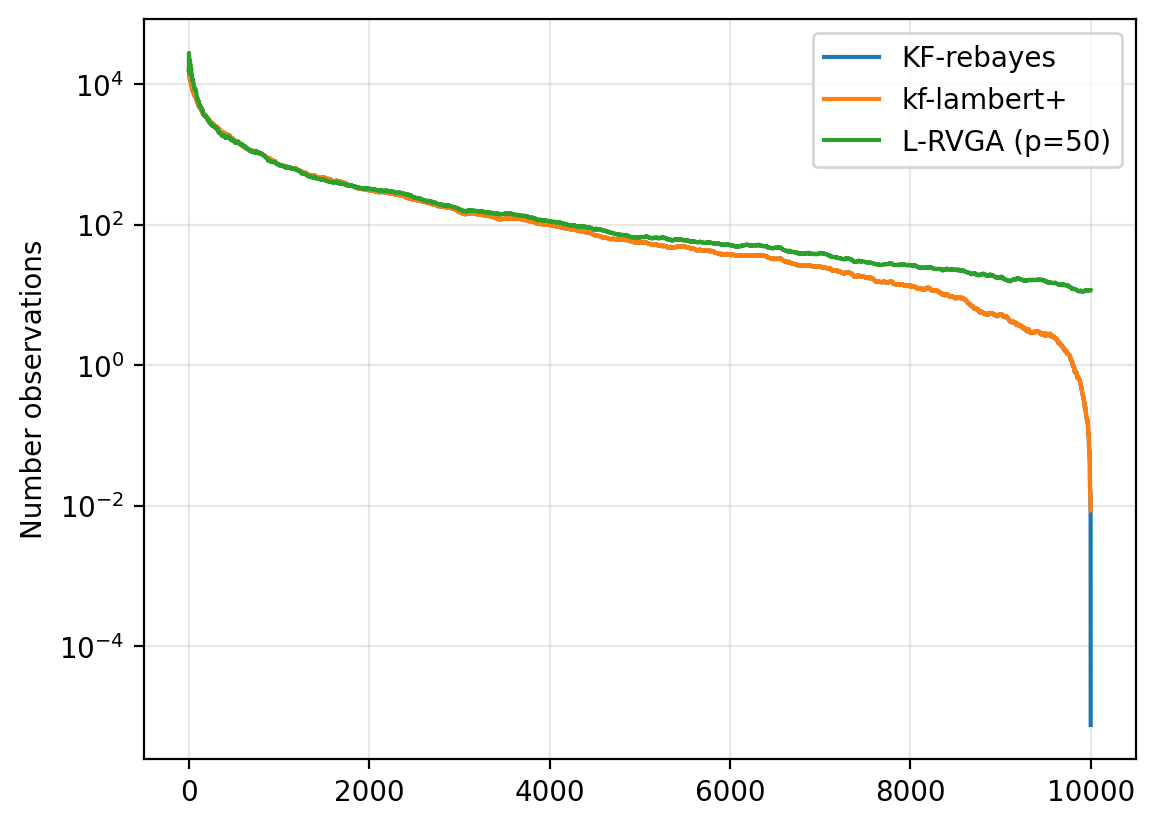

In [156]:
plt.plot(hist["kl"], label="KF-rebayes")
plt.plot(data["ekf-divergence"]["full-kf"].ravel(), label="kf-lambert+")
plt.plot(data["ekf-divergence"]["p-50"].ravel(), label="L-RVGA (p=50)")
plt.legend()
plt.yscale("log")
plt.ylabel("KL(q||p)")
plt.grid(alpha=0.3)
plt.ylabel("Number observations")

In [149]:
dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
dist_ekf = tfd.MultivariateNormalFullCovariance(output.mean, output.cov)

tfd.kl_divergence(dist_ekf, dist_true)

Array(7.632261e-06, dtype=float32)

In [224]:
dist_lofi = tfd.MultivariateNormalFullCovariance(lofi_pmean, lofi_pcov)
tfd.kl_divergence(dist_lofi, dist_true)

Array(2808.9365, dtype=float32)